# Dataset Analysis -- *might not run*
Just some quick work to look at the spread of word frequencies in the training data. Also wanted to compare two tokenization methods.

In [398]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('..')
from lstm_preprocess import load_reviews_folder

In [399]:
bad_train_dict = np.load('../data/dataset_full_dict.npy').item()
bad_test_dict = np.load('../data/dataset_full_test_dict.npy').item()

In [403]:
train_words = set(bad_train_dict.keys())
test_words = set(bad_test_dict.keys())

print("Train dict size: ", len(train_words))
print("Test dict size: ", len(test_words))

Train dict size:  87797
Test dict size:  112664


In [404]:
import random
random.sample(train_words, 10)

['39/40',
 'movie-company',
 'tribe.the',
 'mildly',
 'ossie',
 'tight..every',
 'rochfort',
 'misshapenly-featured',
 'critisism',
 'besxt']

In [405]:
one_shot = test_words - train_words

In [406]:
print("There were %d unique words not seen in the test data" % len(one_shot))

There were 24867 unique words not seen in the test data


In [407]:
print("i.e. %.2f%% of the test vocab." % (100 * len(one_shot) / len(test_words)))

i.e. 22.07% of the test vocab.


In [408]:
import os
import re
from nltk import word_tokenize
def load_reviews_text(folder, num_reviews=0):
    filenames = os.listdir(folder)
    if num_reviews != 0:
        assert num_reviews <= len(filenames)
        filenames = random.sample(filenames, num_reviews)

    def get_next_review():
        for filename in filenames:
            score = int(re.search('.*_([0-9]+)\.txt', filename).group(1))
            with open(os.path.join(folder, filename)) as f:
                text = f.read()
            yield score, text

    return len(filenames), get_next_review

In [409]:
def load_reviews(filename):
    review_sets = [
        filename+"/pos",
        filename+"/neg"
    ]
    
    for review_set in review_sets:
        _, get_review = load_reviews_text(review_set)
        for review in get_review():
            yield review

In [410]:
train_reviews = list(load_reviews("../data/aclImdb/train"))
print("Loaded %d reviews" % len(train_reviews))

Loaded 25000 reviews


In [411]:
df = pd.DataFrame(train_reviews, columns=['scores','text'])
df['text_worse'] = df.text.apply(lambda text: word_tokenize(text.lower()))
#  better, because word_tokenize needs to see the case of letters
df['text_better'] = df.text.apply(lambda text: word_tokenize(text.replace('/', ' / ').replace('-', ' - ').replace('.', ' . ')
                                                           .replace('"', ' " '). replace("''", "' '")))

In [412]:
df.head()

,scores,text,text_worse,text_better
0,9,For a movie that gets no respect there sure ar...,"[for, a, movie, that, gets, no, respect, there...","[For, a, movie, that, gets, no, respect, there..."
1,8,Bizarre horror movie filled with famous faces ...,"[bizarre, horror, movie, filled, with, famous,...","[Bizarre, horror, movie, filled, with, famous,..."
2,7,"A solid, if unremarkable film. Matthau, as Ein...","[a, solid, ,, if, unremarkable, film, ., matth...","[A, solid, ,, if, unremarkable, film, ., Matth..."
3,8,It's a strange feeling to sit alone in a theat...,"[it, 's, a, strange, feeling, to, sit, alone, ...","[It, 's, a, strange, feeling, to, sit, alone, ..."
4,10,"You probably all already know this by now, but...","[you, probably, all, already, know, this, by, ...","[You, probably, all, already, know, this, by, ..."


# Histogram of Review Lengths 
We truncate to length 200 (red line)

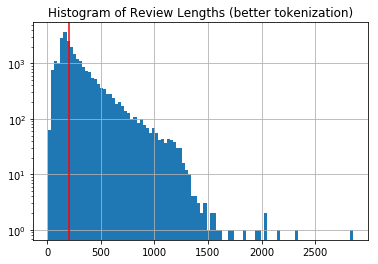

In [413]:
df['length_better'] = df['text_better'].apply(lambda x: len(x))
df['length_better'].hist(bins=100, log=True)
plt.title('Histogram of Review Lengths (better tokenization)')
plt.axvline(x=200, color='red')
plt.show()

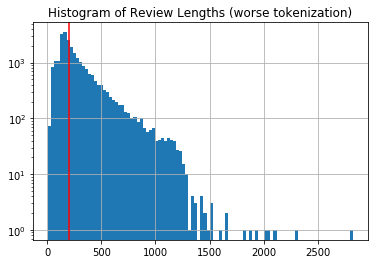

In [414]:
df['length_worse'] = df['text_worse'].apply(lambda x: len(x))
df['length_worse'].hist(bins=100, log=True)
plt.title('Histogram of Review Lengths (worse tokenization)')
plt.axvline(x=200, color='red')
plt.show()

# percent of unknown words in reviews after removing top-k

In [415]:
def percent_unknown(reviews, wordcounts, k):
    sorted_wcs = sorted(wordcounts, key=lambda x: x[1])
    words_unknown = sum([count for _, count in sorted_wcs[:k]])
    total = sum([count for _, count in sorted_wcs])
    return words_unknown/total

In [416]:
percent_unknown(df['text_better'], wordcounts_try2.items(), 1000)

0.00022987792332881623

In [417]:
import math
def plot_unknown(reviews, wordcounts, start=0, end=100, log=False, ylim=None, title=''):
    X = []
    Y = []
    vocab_size = len(wordcounts)
    for i in np.linspace(start, end, 100):
        k = int(i/100 * vocab_size)
        X.append(k)
        if log:
            Y.append(math.log(.000000000000000001+percent_unknown(reviews, wordcounts, k)))
        else:
            Y.append(percent_unknown(reviews, wordcounts, k))
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.plot(X, Y)
    plt.show()

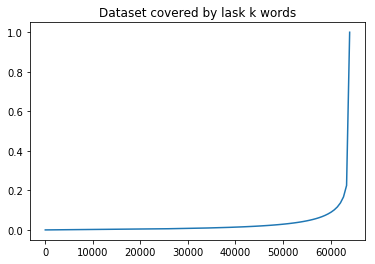

In [383]:
plot_unknown(df['text_better'], wordcounts_try2.items(), log=False, title="Dataset covered by lask k words")

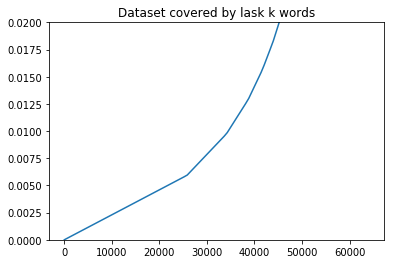

In [418]:
plot_unknown(df['text_better'], wordcounts_try2.items(), start=0, end=100, ylim=[0, 0.02], title="Dataset covered by lask k words")

In [419]:
def plot_avg_counts_by_perc(sorted_wc, ylim=None):
    X = np.linspace(0, 1)
    Y = []
    for x in X:
        Y.append(sorted_wc[int(x*(len(sorted_wc)-1))][1])
    if ylim:
        plt.ylim(ylim)
    plt.plot(X,Y)
    plt.show()

In [129]:
from collections import defaultdict
def get_wordcounts(reviews, max_len=None):
    word_counts = defaultdict(int)
    for review in reviews:
        truncated = review[:max_len]
        for word in truncated:
            word_counts[word.lower()] += 1
    return dict(word_counts)

In [233]:
wordcounts_better = get_wordcounts(df['text_better'], max_len=200)
wordcounts_worse = get_wordcounts(df['text_worse'], max_len=200)

In [420]:
sorted_wc = sorted(wordcounts_better.items(), key=lambda x: x[1])

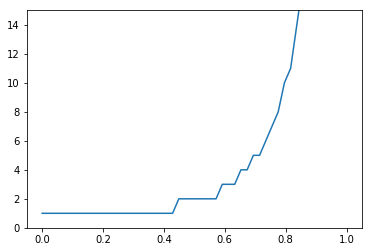

In [421]:
plot_avg_counts_by_perc(sorted_wc, ylim=[0, 15])

In [422]:
import random

In [423]:
def sample_words(sorted_wc, n, perc_range):
    return random.sample(sorted_wc[int(perc_range[0] * len(sorted_wc)):int(perc_range[1] * len(sorted_wc))], n)

In [424]:
sample_words(sorted_wc, 10, [0, 5])

[('arms', 75),
 ('generous', 61),
 ('rock', 529),
 ('chal', 1),
 ('squib.', 1),
 ('antwones', 1),
 ('accord', 3),
 ('out', 9978),
 ('pooh', 3),
 ('globetrotting', 4)]

In [140]:
wordcounts_1 = get_wordcounts(df['try1'])

In [425]:
fake_counts = {w: 1 for w, _ in bad_train_dict.items()}


In [426]:
pd.concat([pd.Series(wordcounts_better), pd.Series(wordcounts_worse), pd.Series(fake_counts)], axis=1)

,0,1,2
a,1.0,1.0,1.0
!,15369.0,15501.0,1.0
#,157.0,157.0,1.0
$,492.0,500.0,1.0
%,273.0,276.0,1.0
&,1964.0,1986.0,1.0
',5620.0,5640.0,1.0
'',19948.0,20225.0,1.0
''a,1.0,1.0,1.0
''bad,1.0,1.0,1.0


In [213]:
pd.Series(fake_counts)

a            30948    1
!                26       1
#                1018     1
$                1715     1
%                7013     1
&                122      1
'                832      1
''               41       1
''a              59008    1
''bad            19307    1
''dark           23370    1
''empire         25627    1
''family         53377    1
''gaslight       54334    1
''heart          75800    1
''holy           68349    1
''human          75799    1
''if             67166    1
''ned            55224    1
''nice           46554    1
''oh             83513    1
''peeping        33026    1
''professionals  68686    1
''ranma          56385    1
''raptors        78574    1
''return         25628    1
''saint          33021    1
''scarface       58142    1
''sea            11501    1
''terrorists     78573    1
                         ..
¾                72077    1
¿acting          82158    1
¿remember        57286    1
¿special         82157    1
à                292

In [187]:
import random
print("\n".join(random.sample(wordcounts_better.keys(), 10)))

unaccompanied
ltas
lambast
feinstein
testings
grifting
slashers
amphlett
mail
view.it


In [195]:
print("\n".join(random.sample(wordcounts_worse.keys(), 10)))

digressing
distillery
feardotcom
wolhiem
'marry
brosnan.
anonymous
friggin
out-of-focus
eislin


In [134]:
print("%d words with better parsing vs. %d words with worse parsing" %
        (len(wordcounts_better.keys()), len(wordcounts_worse.keys())))

94143 words with better parsing vs. 114526 words with worse parsing


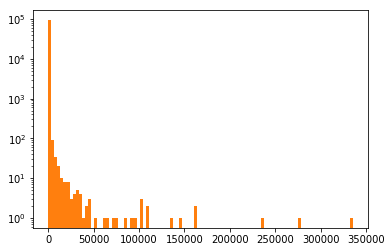

In [30]:
counts = [count for word, count in wordcounts_better.items()]
plt.hist(counts, bins=100, log=True)
plt.title('Histogram of word frequencies')
plt.show()